<a href="https://colab.research.google.com/github/eomorozova/NMA-DL-Project/blob/main/t_SNE_Steinmetz_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
#@title Importing Libraries

import os, requests
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.patches as mpatches

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
#@title CUDA Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
#@title Plotting params

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [4]:
#@title Clone FFT-accelerated t-SNE repository
import os, requests
import sys

!git clone https://github.com/KlugerLab/FIt-SNE.git 
!apt-get install libfftw3-dev
!g++ -std=c++11 -O3  /content/FIt-SNE/src/sptree.cpp /content/FIt-SNE/src/tsne.cpp /content/FIt-SNE/src/nbodyfft.cpp  -o /content/FIt-SNE/bin/fast_tsne -pthread -lfftw3 -lm -Wno-address-of-packed-member

sys.path.append(os.path.abspath('/content/FIt-SNE/'))
from fast_tsne import fast_tsne 

Cloning into 'FIt-SNE'...
remote: Enumerating objects: 922, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 922 (delta 74), reused 64 (delta 23), pack-reused 780
Receiving objects: 100% (922/922), 31.93 MiB | 22.46 MiB/s, done.
Resolving deltas: 100% (513/513), done.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-long3 libfftw3-quad3 libfftw3-single3
0 upgraded, 5 newly installed, 0 to remove and 37 not upgraded.
Need to get 3,766 kB of archives.
After this operation, 21.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libfftw3-long3 amd64 3.3.7-1 [308 kB]
Get:2 http://archive.ubuntu.com/

In [5]:
#@title Clone Elephant (Electrophysiology analysis toolkit)

!git clone https://github.com/NeuralEnsemble/elephant.git
!git clone https://github.com/NeuralEnsemble/python-neo.git

import sys
import os 
sys.path.append(os.path.abspath('/content/elephant/'))
sys.path.append(os.path.abspath('/content/python-neo/'))
!pip install quantities

from elephant.spike_train_dissimilarity import victor_purpura_distance
from elephant.spike_train_dissimilarity import van_rossum_distance
import quantities as pq
from neo.core import SpikeTrain

Cloning into 'elephant'...
remote: Enumerating objects: 3183, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 3183 (delta 31), reused 56 (delta 13), pack-reused 3050
Receiving objects: 100% (3183/3183), 4.08 MiB | 15.77 MiB/s, done.
Resolving deltas: 100% (2142/2142), done.
Cloning into 'python-neo'...
remote: Enumerating objects: 23894, done.
remote: Counting objects: 100% (1931/1931), done.
remote: Compressing objects: 100% (722/722), done.
remote: Total 23894 (delta 1380), reused 1639 (delta 1169), pack-reused 21963
Receiving objects: 100% (23894/23894), 101.18 MiB | 21.11 MiB/s, done.
Resolving deltas: 100% (17991/17991), done.
     |████████████████████████████████| 85 kB 2.4 MB/s 
  Created wheel for quantities: filename=quantities-0.12.5-py3-none-any.whl size=80135 sha256=9f0684252bffa51b4dbac95ddaef8d80a68b2f652341aed4a082f259cdea0f68
  Stored in directory: /root/.cache/pip/wheels/67/e7/32/0bb6d5bd0f619e583b

# Load and plot Steinmetz neuropixel dataset

In [6]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [10]:
#@title Data loading
import numpy as np
import  sklearn

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

dat = alldat[11]
#del alldat

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

In [7]:
#@title Loading spike times and waveforms 

fname1 = ['steinmetz_st.npz']
#fname1.append('steinmetz_wav.npz')
url2 = ["https://osf.io/4bjns/download"]
#url2.append("https://osf.io/ugm9v/download")


for j in range(len(url2)):
  if not os.path.isfile(fname1[j]):
    try:
      r = requests.get(url2[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname1[j], "wb") as fid:
          fid.write(r.content)


dat_ST = np.load('steinmetz_st.npz', allow_pickle=True)['dat']
datst = dat_ST[11]
del dat_ST

In [ ]:
# Make a plot of which brain areas are present in each dataset
# note that region 4 ("other ctx" are neurons that were not able to be classified)
# region 4 does not correspond to brain_group 4, which are all cortical neurons outside of visual cortex
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(alldat)), dtype=bool)
for j, d in enumerate(alldat):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
    yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(alldat)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
    for area in group:
        ytickobjs[counter].set_color(color)
        counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)

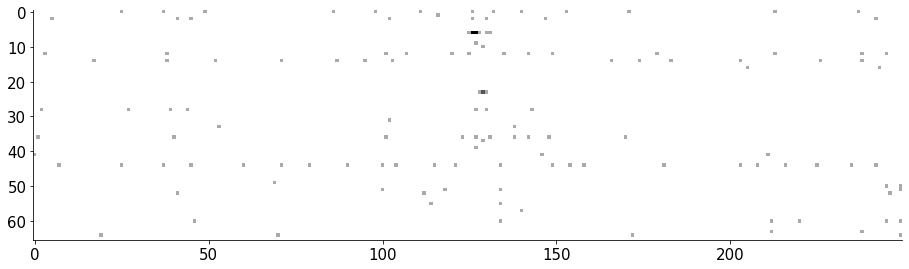

In [11]:
#@title Plot spike raster

# dimentions 1-neuron, 2-trial, 3-time
#dat = alldat[11]
region=dat['brain_area']
#print(region)
#spkdat=(dat['spks'])
response=dat['response']
response.shape
spkdat=(dat['spks'][region=='VISp'][:,response>=0])
spkdat=(dat['spks'][region=='VISp'])
spkdat.shape
plt.imshow(spkdat[:,2,:],cmap='gray_r')
#plt.scatter(np.arange(0,np.squeeze(spkdat[:,2,:]).shape[1]),np.squeeze(spkdat[:,2,:]))

#np.arange(0,(np.squeeze(spkdat[:,2,:].shape[1]))).shape
#np.squeeze(spkdat[:,2,:]).shape

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


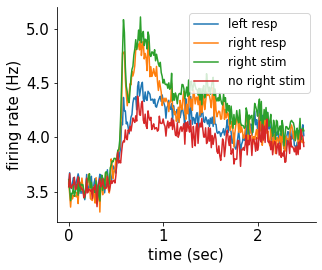

In [12]:
#@title Plots mean firing rates of all the neurons

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
#dat = alldat[11]
print(dat.keys())

dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

ax = plt.subplot(1,5,1)
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response>=0].mean(axis=(0,1))) # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response<0].mean(axis=(0,1))) # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right>0].mean(axis=(0,1))) # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right==0].mean(axis=(0,1))) # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');

# Visualize the spike pattenrs from Steinmetz dataset using t-SNE

In [92]:
#@title Label based on the intensity of the right stimuli
vis_right = dat['contrast_right'] 
vis_left = dat['contrast_left'] # 0 - low - high

# Label the data based on whether the stimulus was presented on the right
#vis_resp=np.empty(len(vis_right))
#vis_resp[np.where(vis_right>0)[0]]=0
#vis_resp[np.where(vis_right==0)[0]]=1

vis_resp=np.empty(len(vis_right))
vis_resp[vis_right==0]=0
vis_resp[vis_right==0.25]=1
vis_resp[vis_right==0.5]=2
vis_resp[vis_right==1]=3
#print(vis_resp)


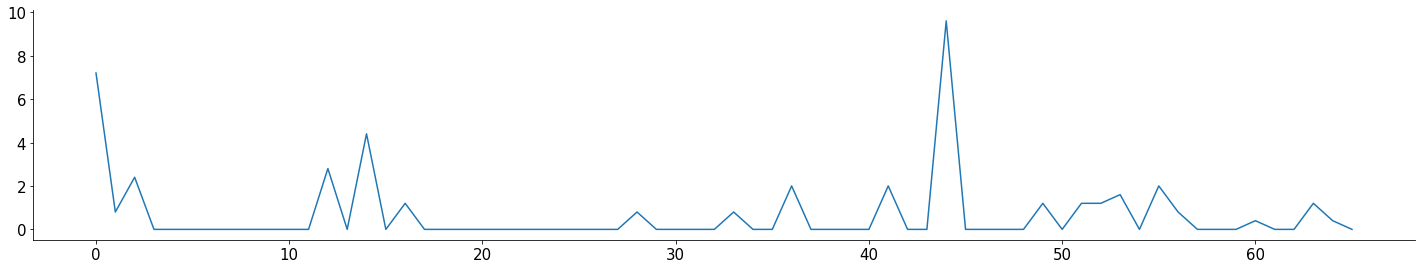

In [14]:
# transform the spiking time series into a feature space by calculating various properties of the series that might be important

# calculate mean firing rate of the neurons in primary visual cortex
region=dat['brain_area']

spikes = dat['spks'][region=='VISp'].mean(axis = 2).T #across time for each trial
#spikes = dat['spks'][region=='VISp'].mean(axis = 0) #across neurons for each trial

binsize=0.01
meanfr = spikes*1/binsize
meanfr.shape
plt.plot(meanfr[1,:])

In [ ]:
# take spike times 1 second after the visual stimulus was presented
#stimulus @ 0.5 sec
spk= datst['ss'][region=='VISp']
spk_stim=[]
for j in range(0,spk.shape[1]): # by trials
  for i in range(0,spk.shape[0]): # by neurons
    spk1 = spk[i,j]
    spk_stim1  = spk1[(spk1 >= 0.5) & (spk1 <= 1.5)]*1000
    spk_stim.append(spk_stim1)
 
spkstim = np.reshape(spk_stim,(spk.shape[1],spk.shape[0])).T

In [ ]:
tau = 10.0 * pq.ms

spk= datst['ss'][region=='VISp']

vr1=[]
for jj in range(0,spkstim.shape[1]): # by trials
  print(jj)
  for i in range(0,spkstim.shape[0]): # by neurons
    for j in range(0,spkstim.shape[0]): # by neurons
      if i<j:
        st_a = SpikeTrain(spkstim[i,jj], units='ms', t_stop= 1500.0)
        st_b = SpikeTrain(spkstim[j,jj], units='ms', t_stop= 1500.0)
        vr = van_rossum_distance([st_a,st_b], tau)[0,1]
        vr1.append(vr)

vr2=np.hstack(vr1)    
vrAll = vr2.reshape(spk.shape[1],int(len(vr1)/spk.shape[1]))


In [48]:
# make feature vectors of mean firing rates and similarity distances
All=np.concatenate((meanfr,vrAll),axis=1)

In [106]:
# Do PCA and keep 50 dimensions
#X = meanfr - meanfr.mean(axis=0)
#X = All - All.mean(axis=0)
X = vrAll - vrAll.mean(axis=0)
U, s, V = np.linalg.svd(X, full_matrices=False)
X50 = np.dot(U, np.diag(s))[:,:50]

In [109]:
#@title Running t-SNE on the full PCA-reduced dataset 
# This uses perplexity 30 and PCA initialization.
# It runs for 750 iterations with learning rate N/12.

#%time Z = fast_tsne(X50,perplexity=30)
#%time Z = fast_tsne(meanfr,perplexity=50)
#%time Z = fast_tsne(vrAll, perplexity=30)

# do exaggeration
#%time Z = fast_tsne(X50, late_exag_coeff=1.2)

# make the kernel more/less heavy-tailed
#The default Cauchy kernel corresponds to df=1. Large df corresponds to the Gaussian kernel.
%time Z = fast_tsne(X50, df=.8)

CPU times: user 70.6 ms, sys: 74.1 ms, total: 145 ms
Wall time: 12 s


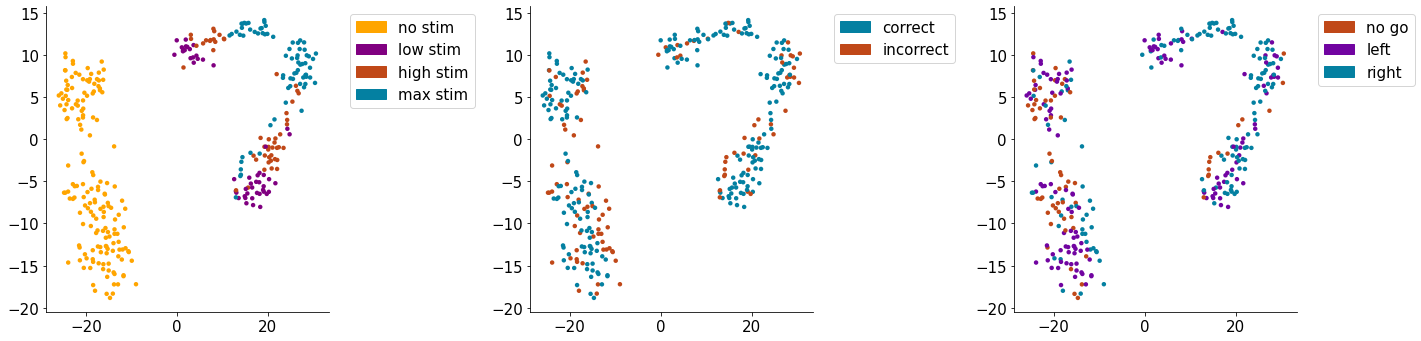

In [110]:
# plot the result of t-SNE

plt.figure(figsize=(20,5))

# colorcode based on the stimulus intensity on the right
col=np.arange(4)
plt.subplot(1,3,1)
#cax=plt.scatter(Z[:,0], Z[:,1], c=col[vis_resp.astype('int8')],cmap=plt.cm.get_cmap('Accent', 4), s=20, edgecolors='none')
#cbar = plt.colorbar(cax, ticks=[0,1,2,3])
#cbar.ax.set_yticklabels(['0 (no stimulus)', '0.25', '0.5','1 (max intensity)'])  # vertically oriented colorbar

# colorcode based on whether the stimulus is on the right or not
col = np.array(['#FFA500','#800080','#C04818','#0480A1'])
plt.scatter(Z[:,0], Z[:,1], c=col[vis_resp.astype('int8')], s=20, edgecolors='none')
pop_a = mpatches.Patch(color=col[0], label='no stim')
pop_b = mpatches.Patch(color=col[1], label='low stim')
pop_c = mpatches.Patch(color=col[2], label='high stim')
pop_d = mpatches.Patch(color=col[3], label='max stim')
plt.legend(handles=[pop_a,pop_b,pop_c,pop_d],bbox_to_anchor=(1.05, 1),loc='upper left')

# colorcode based on the correct and incorrect trials
is_correct = np.sign(dat['response'])==np.sign(vis_left-vis_right)
col = np.array(['#C04818','#0480A1'])
plt.subplot(1,3,2)
plt.scatter(Z[:,0], Z[:,1], c=col[is_correct.astype('int8')], s=20, edgecolors='none')
pop_b = mpatches.Patch(color=col[0], label='incorrect')
pop_a = mpatches.Patch(color=col[1], label='correct')
plt.legend(handles=[pop_a,pop_b],bbox_to_anchor=(1.05, 1),loc='upper left')

# colorcode based on the direction of wheel rotation
response=np.sign(dat['response'])
col = np.array(['#C04818','#7104A1','#0480A1'])
plt.subplot(1,3,3)
plt.scatter(Z[:,0], Z[:,1], c=col[response.astype(int)], s=20, edgecolors='none')
pop_a = mpatches.Patch(color=col[0], label='no go')
pop_b = mpatches.Patch(color=col[1], label='left')
pop_c = mpatches.Patch(color=col[2], label='right')
plt.legend(handles=[pop_a,pop_b,pop_c],bbox_to_anchor=(1.05, 1),loc='upper left')

plt.tight_layout()


# Visualize Steinmetz dataset using t-SNE from multiple sessions

In [ ]:
# get the neurons from visual cortex from all the experiments
spikesall=[]
vis_resp_all=[]
is_correct_all=[]

for i in range(len(alldat)):
  dat = alldat[i]
  region=dat['brain_area']
  #spikes = dat['spks'][region=='VISp'].mean(axis = 2).T #across time for each trial
  spikes = dat['spks'][region=='VISp'].mean(axis = 0) #across neurons for each trial
  #spikesall = np.append(spikesall, spikes)  
  spikesall.append(spikes)

  #label based on the intensity of the right stimuli
  vis_right = dat['contrast_right'] # 0 - low - high
  vis_left = dat['contrast_left'] # 0 - low - high

  vis_resp=np.empty(len(vis_right))
  vis_resp[np.where(vis_right==0)[0]]=0
  vis_resp[np.where(vis_right==0.25)[0]]=1
  vis_resp[np.where(vis_right==0.5)[0]]=2
  vis_resp[np.where(vis_right==1)[0]]=3
  vis_resp_all = np.append(vis_resp_all, vis_resp)  

  is_correct = np.sign(dat['response'])==np.sign(vis_left-vis_right)
  is_correct_all = np.append(is_correct_all, is_correct)  

spikesall = np.concatenate(spikesall) 
vis_resp_all = vis_resp_all[~np.isnan(spikesall).any(axis=1)]
is_correct_all = is_correct_all[~np.isnan(spikesall).any(axis=1)]
spikesall = spikesall[~np.isnan(spikesall).any(axis=1)]

In [ ]:
# Do PCA and keep 50 dimensions
#X = meanfr - meanfr.mean(axis=0)
X = spikesall - spikesall.mean(axis=0)
U, s, V = np.linalg.svd(X, full_matrices=False)
X50 = np.dot(U, np.diag(s))[:,:50]

In [ ]:
#@title Running t-SNE on the full PCA-reduced dataset

# perplexity 30 and PCA initialization.
# It runs for 750 iterations with learning rate N/12.

#%time Z = fast_tsne(X50,theta=0.5, perplexity=30)

# do exaggeration
%time Z = fast_tsne(X50, late_exag_coeff=2)

# make the kernel more/less heavy-tailed
#The default Cauchy kernel corresponds to df=1. Large df corresponds to the Gaussian kernel.
#%time Z = fast_tsne(X50, df=.5)

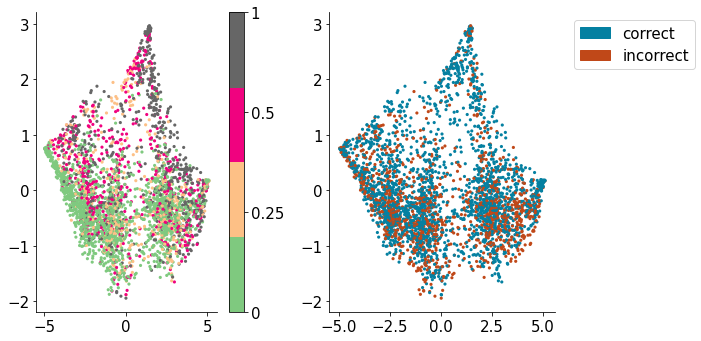

In [ ]:
# plot the result of t-SNE

plt.figure(figsize=(10,5))

# colorcode based on the stimulus intensity on the right
col=np.arange(4)
plt.subplot(1,2,1)
cax=plt.scatter(Z[:,0], Z[:,1], c=col[vis_resp_all.astype('int8')],cmap=plt.cm.get_cmap('Accent', 4), s=10, edgecolors='none')
#cax=plt.scatter(Z[:,0], Z[:,1], s=20, edgecolors='none')
cbar = plt.colorbar(cax, ticks=[0,1,2,3])
cbar.ax.set_yticklabels(['0', '0.25', '0.5','1'])  # vertically oriented colorbar

# colorcode based on the correct and incorrect trials
col = np.array(['#C04818','#0480A1'])
plt.subplot(1,2,2)
plt.scatter(Z[:,0], Z[:,1], c=col[is_correct_all.astype('int8')], s=10, edgecolors='none')
pop_b = mpatches.Patch(color=col[0], label='incorrect')
pop_a = mpatches.Patch(color=col[1], label='correct')
plt.legend(handles=[pop_a,pop_b],bbox_to_anchor=(1.05, 1),loc='upper left')

plt.tight_layout()
